In [1]:
# 1. লাইব্রেরি ইম্পোর্ট
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

In [2]:
# 2. ডেটা লোড
# -------------------------------
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    df = pd.read_csv(filename)
    print(f"Dataset '{filename}' loaded successfully!")

Saving crop_yield.csv to crop_yield.csv
Dataset 'crop_yield.csv' loaded successfully!


In [3]:
# 3. ডেটা এক্সপ্লোরেশন
# -------------------------------
print(df.info())
print(df.describe())
print("Missing Values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB
None
          Rainfall_mm  Temperature_Celsius  Days_to_Harvest  \
count  1000000.000000       1000000.000000   1000000.000000   
mean       549.981901    

In [4]:
# 4. Outlier Handling
# -------------------------------
# Yield তে negative value cap করা
df['Yield_tons_per_hectare'] = df['Yield_tons_per_hectare'].apply(lambda x: max(x, 0))


In [5]:
# 5. Feature Engineering
# -------------------------------
# Interaction feature: Rainfall per day
df['Rainfall_per_day'] = df['Rainfall_mm'] / df['Days_to_Harvest']

numeric_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare', 'Rainfall_per_day']
categorical_cols = ['Region', 'Soil_Type', 'Crop', 'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition']

In [6]:
# 6. Missing Value Handling
# -------------------------------
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df = df.drop_duplicates()

In [7]:
# 7. Encode Categorical Variables
# -------------------------------
df_encoded = pd.get_dummies(df, drop_first=True)

In [8]:
# 8. Scale Numeric Columns
# -------------------------------
scaler = StandardScaler()
numeric_cols_to_scale = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Rainfall_per_day']
df_encoded[numeric_cols_to_scale] = scaler.fit_transform(df_encoded[numeric_cols_to_scale])

In [9]:
# 9. Create Binary Yield Classes (Low / High)
# -------------------------------
# Low: Yield <= 4, High: Yield > 4
df_encoded['Yield_Class'] = df['Yield_tons_per_hectare'].apply(lambda x: 'Low' if x <= 4 else 'High')

# Drop any missing (যদি থাকে)
df_encoded.dropna(subset=['Yield_Class'], inplace=True)

In [10]:
# 10. Train/Test Split
# -------------------------------
X = df_encoded.drop(['Yield_tons_per_hectare', 'Yield_Class'], axis=1)
y = df_encoded['Yield_Class']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Low=0, High=1

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [11]:
# 11. Handle Imbalanced Classes
# -------------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


Column: Region
Region
North    250173
West     250074
South    250054
East     249699
Name: count, dtype: int64


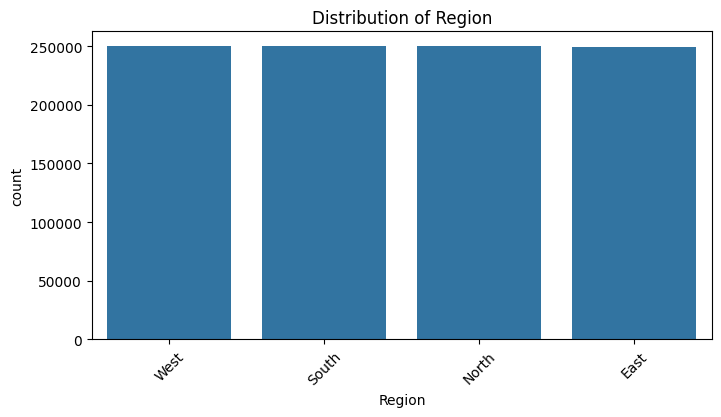


Column: Soil_Type
Soil_Type
Sandy     167119
Loam      166795
Chalky    166779
Silt      166672
Clay      166352
Peaty     166283
Name: count, dtype: int64


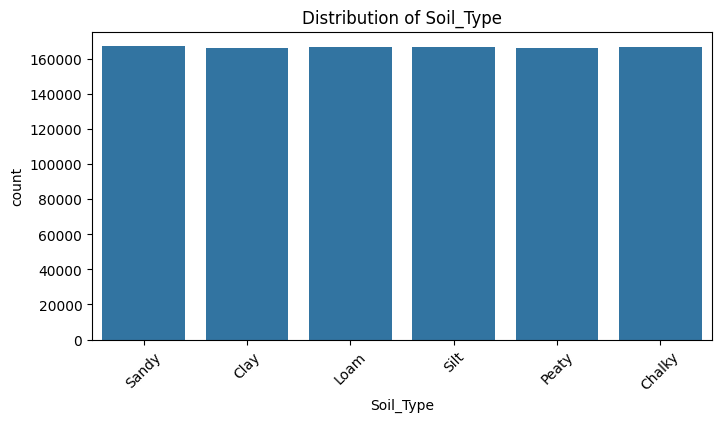


Column: Crop
Crop
Maize      166824
Rice       166792
Barley     166777
Wheat      166673
Cotton     166585
Soybean    166349
Name: count, dtype: int64


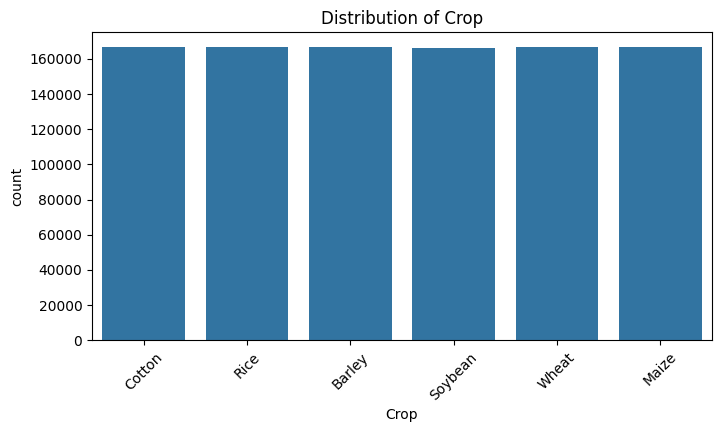


Column: Weather_Condition
Weather_Condition
Sunny     333790
Rainy     333561
Cloudy    332649
Name: count, dtype: int64


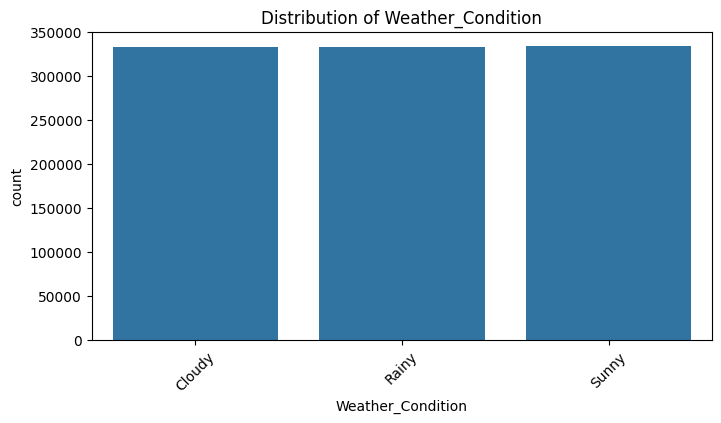


Column: Rainfall_mm (Numeric)
count    1000000.000000
mean         549.981901
std          259.851320
min          100.000896
25%          324.891090
50%          550.124061
75%          774.738520
max          999.998098
Name: Rainfall_mm, dtype: float64


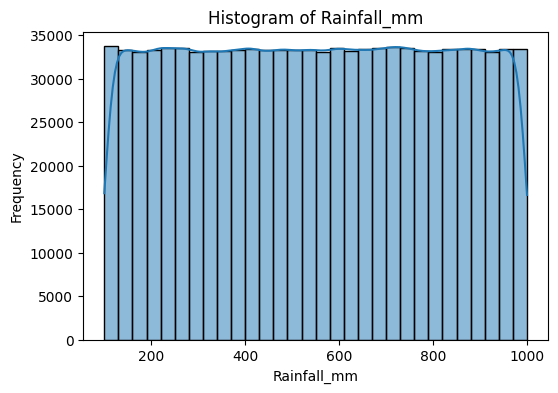


Column: Temperature_Celsius (Numeric)
count    1000000.000000
mean          27.504965
std            7.220608
min           15.000034
25%           21.254502
50%           27.507365
75%           33.753267
max           39.999997
Name: Temperature_Celsius, dtype: float64


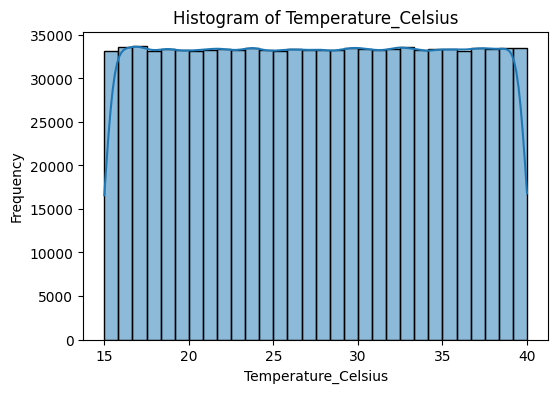


Column: Days_to_Harvest (Numeric)
count    1000000.000000
mean         104.495025
std           25.953412
min           60.000000
25%           82.000000
50%          104.000000
75%          127.000000
max          149.000000
Name: Days_to_Harvest, dtype: float64


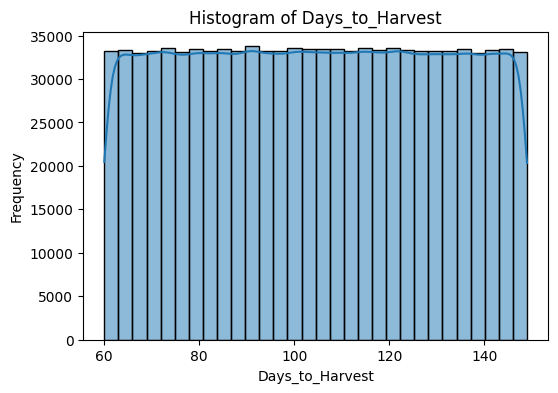


Column: Yield_tons_per_hectare (Numeric)
count    1000000.000000
mean           4.649518
std            1.696443
min            0.000000
25%            3.417637
50%            4.651808
75%            5.879200
max            9.963372
Name: Yield_tons_per_hectare, dtype: float64


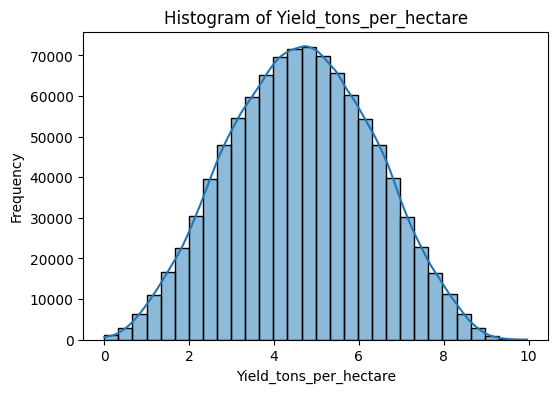


Column: Rainfall_per_day (Numeric)
count    1000000.000000
mean           5.631751
std            3.149053
min            0.671348
25%            3.109346
50%            5.263282
75%            7.530873
max           16.666609
Name: Rainfall_per_day, dtype: float64


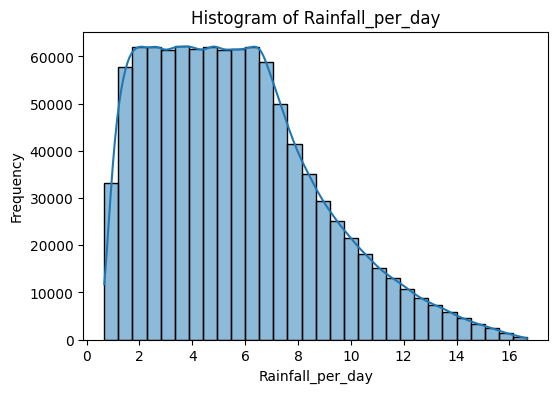

In [12]:
# -------------------------------
# 12. Column-wise Distribution
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical columns
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64','float64']]

# Categorical distribution
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())

    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

# Numeric distribution
for col in numeric_cols:
    print(f"\nColumn: {col} (Numeric)")
    print(df[col].describe())

    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


Random Forest Accuracy: 0.911065
              precision    recall  f1-score   support

        High       0.94      0.92      0.93    127772
         Low       0.86      0.90      0.88     72228

    accuracy                           0.91    200000
   macro avg       0.90      0.91      0.90    200000
weighted avg       0.91      0.91      0.91    200000



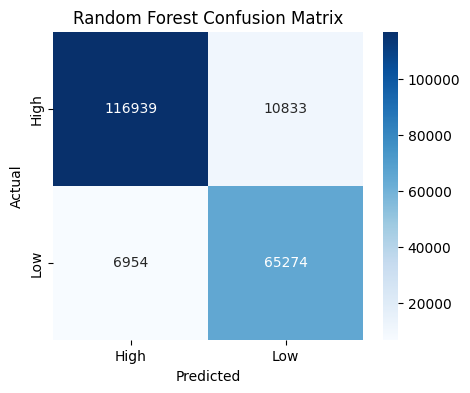

In [13]:
# 12. Random Forest Model
# -------------------------------
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=le.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

XGBoost Accuracy: 0.912535
              precision    recall  f1-score   support

        High       0.95      0.91      0.93    127772
         Low       0.85      0.92      0.88     72228

    accuracy                           0.91    200000
   macro avg       0.90      0.91      0.91    200000
weighted avg       0.92      0.91      0.91    200000



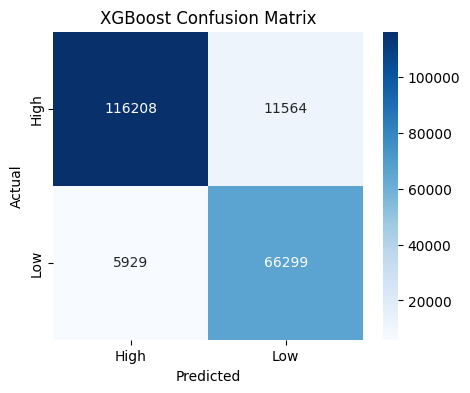

In [14]:
# 13. XGBoost Model
# -------------------------------
xgb = XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, zero_division=0, target_names=le.classes_))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Naïve Bayes Accuracy: 0.83243
              precision    recall  f1-score   support

        High       0.93      0.80      0.86    127772
         Low       0.72      0.89      0.79     72228

    accuracy                           0.83    200000
   macro avg       0.82      0.84      0.83    200000
weighted avg       0.85      0.83      0.84    200000



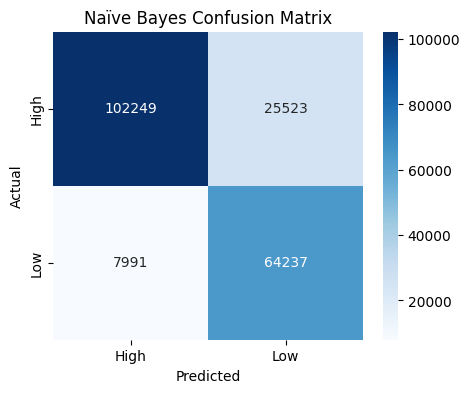

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

# -------------------------------
# 15. Naïve Bayes
# -------------------------------
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:,1]  # probability for High class

print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Naïve Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Gradient Boosting Accuracy: 0.912205
              precision    recall  f1-score   support

        High       0.95      0.91      0.93    127772
         Low       0.85      0.92      0.88     72228

    accuracy                           0.91    200000
   macro avg       0.90      0.91      0.91    200000
weighted avg       0.92      0.91      0.91    200000



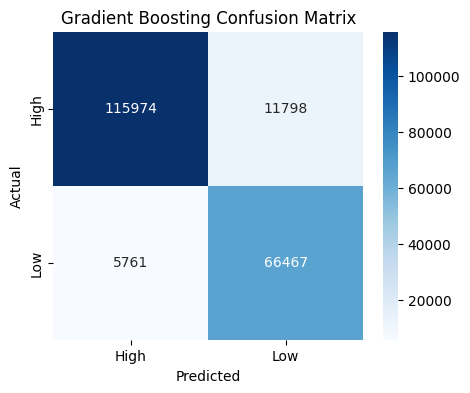

In [17]:
# 16. Gradient Boosting
# -------------------------------
gbr = GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=42)
gbr.fit(X_train_res, y_train_res)
y_pred_gbr = gbr.predict(X_test)
y_prob_gbr = gbr.predict_proba(X_test)[:,1]  # probability for High class

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gbr))
print(classification_report(y_test, y_pred_gbr, target_names=le.classes_))

cm_gbr = confusion_matrix(y_test, y_pred_gbr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_gbr, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

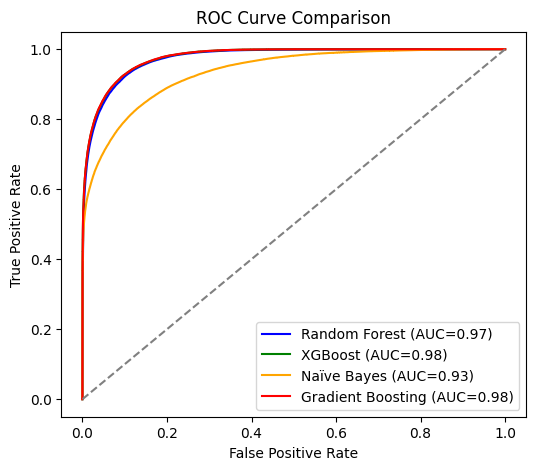

In [21]:
# -------------------------------
# 17. ROC Curves Comparison
# -------------------------------
plt.figure(figsize=(6,5))

# Random Forest
y_prob_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC={roc_auc_rf:.2f})')

# XGBoost
y_prob_xgb = xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, color='green', label=f'XGBoost (AUC={roc_auc_xgb:.2f})')

# Naive Bayes
y_prob_nb = nb.predict_proba(X_test)[:,1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.plot(fpr_nb, tpr_nb, color='orange', label=f'Naïve Bayes (AUC={roc_auc_nb:.2f})')

# Gradient Boosting
y_prob_gbr = gbr.predict_proba(X_test)[:,1]
fpr_gbr, tpr_gbr, _ = roc_curve(y_test, y_prob_gbr)
roc_auc_gbr = auc(fpr_gbr, tpr_gbr)
plt.plot(fpr_gbr, tpr_gbr, color='red', label=f'Gradient Boosting (AUC={roc_auc_gbr:.2f})')

# Diagonal
plt.plot([0,1], [0,1], color='grey', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

/tmp/ipython-input-2480836615.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_values, palette='viridis')


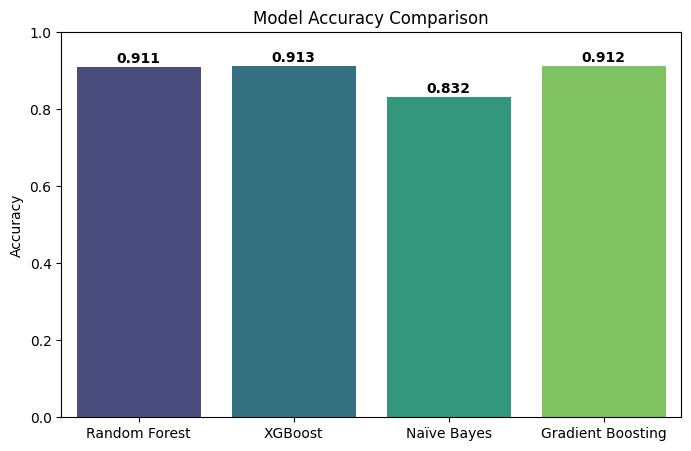

In [19]:
# -------------------------------
# Accuracy Comparison Plot
# -------------------------------
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values
models = ['Random Forest', 'XGBoost', 'Naïve Bayes', 'Gradient Boosting']
accuracy_values = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_gbr)
]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracy_values, palette='viridis')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()
